# PSO
- Particle Swarm Optimization
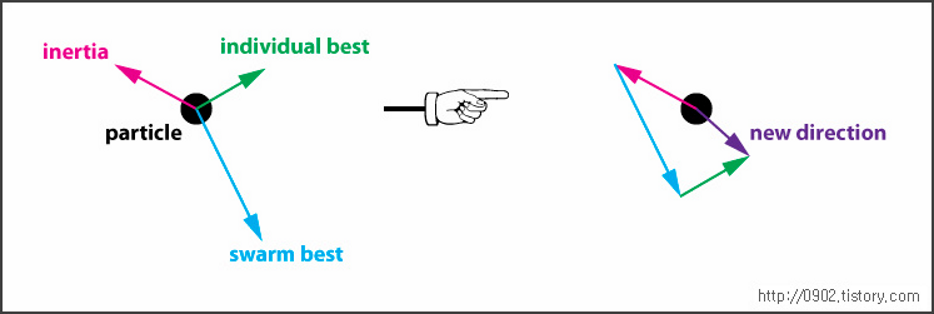
- 군집 내 각 particle은 이동하면서 `pbest`를 가짐(개인 최적 위치)
- 군집은 이동하면서 `gbest`를 가짐(군집 내 각 particle 중 가장 작은 `pbest`)
- 이동하는 방식

```
새로운 위치 = 현재 위치 + 새로운 속도

새로운 속도 = 가중치 * 기존 속도 [inertia]
            + 가속계수1 * (pbest - 현재 위치) [cognitive]
            + 가속계수2 * (gbest - 현재 위치) [social]
```

- 가중치(`w`), 가속계수1(`c1`), 가속계수2(`c2`)에 따라 최적값을 찾는 시간이나 수렴하는 곳이 달라진다.

- pseudo code

```
For 각 입자
    입자별 위치(position)와 속도(velocity)를 임의의 값으로 초기화
END
Do
    For 각 입자
        fitness value 계산 (성공 측정)
        If fitness value 가 best fitness value(pBest)보다 낫다면
            현재 value를 새로운 pBest로 변경
    END

가장 좋은 fitness 값을 가지고 있는 입자를 gBest로 선택
    For 각 입자
        입자 속도(velocity)계산
        계산한 속도를 가지고 입자의 위치(position) 업데이트
    End
최대 반복 횟수나 최소 에러 기준에 도달하지 않는 경우 계속 진행

```

# Simple PSO
https://laonjena227.tistory.com/8

In [1]:
import numpy as np

class PSO(object):
    """
    Class implementing PSO algorithm
    """
    def __init__(self, func, init_pos, n_particles):
        """
        Initialize the key variables.
        
        Args:
            fun (function): the fitness function to optimize
            init_pos(array_like):
            n_particles(int): the number of particles of the swarm.
        """
        self.func = func
        self.n_particles = n_particles
        self.init_pos = init_pos
        self.particle_dim = len(init_pos)
        self.particles_pos = np.random.uniform(size=(n_particles, self.particle_dim)) \
                            * self.init_pos
        self.velocities = np.random.uniform(size=(n_particles, self.particle_dim))
        #Initilize the best positions
        self.g_best = init_pos
        self.p_best = self.particles_pos
        
    
    def update_position(self, x, v):
        """
        Update particle position
        
        Args:
            x (array-like): particle current position
            v (array-like): particle current velocity
        
        Returns:
            The updated position(array-like)
        """
        x = np.array(x)
        v = np.array(v)
        new_x = x + v
        return new_x
    
    
    def update_velocity(self, x, v, p_best, g_best, c0=0.5, c1=1.5, w=0.75):
        """
            Update particle velocity
            
            Args:
                x(array-like): particle current position
                v (array-like): particle current velocity
                p_best(array-like): the best position found so far for a particle
                g_best(array-like): the best position regarding all the particles found so far
                c0 (float): the congnitive scaling constant, 인지 스케일링 상수
                c1 (float): the social scaling constant
                w (float): the inertia weight, 관성 중량
                
            Returns:
                The updated velocity (array-like).
        """
        x = np.array(x)
        v = np.array(v)
        assert x.shape == v.shape, "Position and velocity must have same shape."
        # a random number between 0 and 1
        r = np.random.uniform()
        p_best = np.array(p_best)
        g_best = np.array(g_best)
        
        new_v = w*v + c0*r*(p_best - x) + c1*r*(g_best-x)
        return new_v
    
    
    def optimize(self, tolerance=None, maxiter=200):
        """
        Run the PSO optimization process utill the stoping critera is met.
        Cas for minization. The aim is to minimize the cost function
        
        Args:
            maxiter (int): the maximum number of iterations before stopping the optimization
            
        Returns:
            The best solution found (array-like)
        """
        for _ in range(maxiter):
            for i in range(self.n_particles):
                x = self.particles_pos[i]
                v = self.velocities[i]
                p_best = self.p_best[i]
                self.velocities[i] = self.update_velocity(x, v, p_best, self.g_best)
                self.particles_pos[i] = self.update_position(x,v)
                # Update the best position for particle i
                if self.func(self.particles_pos[i]) < self.func(p_best):
                    self.p_best[i] = self.particles_pos[i]
                # Update the best position overall
                if self.func(self.particles_pos[i]) < self.func(self.g_best):
                    self.g_best = self.particles_pos[i]
                    
                    if (tolerance is not None) and (self.func(self.g_best) <= tolerance):
                        return self.g_best, self.func(self.g_best)
                    
        return self.g_best, self.func(self.g_best)
    
    
def sphere(x):
    """
        In 3D : f(x,y,z) = x² + y² + z²
    """
    return np.sum(np.square(x))

## 2D 원 최적값 찾기
- 정답: (0, 0)

In [2]:
pso = PSO(sphere, init_pos=np.ones(2), n_particles=100)

In [3]:
pso.optimize()

(array([-1.93846294e-08,  4.04614749e-09]), 3.9213516688653234e-16)

## bike 수요 800이 되게 하는 최적값 찾기

In [11]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('bike.csv')
drop_columns = ['datetime', 'casual', 'registered']
df.drop(drop_columns, axis=1, inplace=True)

y = df['count']
X = df.drop(['count'], axis=1)

from xgboost import XGBRegressor

xgb = XGBRegressor().fit(X.values, y.values)

In [12]:
def loss_function(x):
    pred = xgb.predict(np.array([x]))[0]
    return abs(pred-40)

In [13]:
init_pos = X.iloc[0].values
n_particles = 100

In [14]:
pso = PSO(loss_function, init_pos, n_particles)

In [15]:
pos, cost = pso.optimize(tolerance=0.2)

In [16]:
xgb.predict([pos])

array([40.047653], dtype=float32)

In [17]:
pos

array([ 0.99104369,  0.62211799,  0.37217907,  0.46179036,  1.5818042 ,
       10.34613217,  6.02352499,  0.34568006])

### 단점
boundary 설정이 없어서 X가 가질 수 있는 범위를 벗어난다.

In [19]:
gbest = pos
desc = X.describe()

for i, col in enumerate(X.columns):
    if gbest[i] < desc.loc['min', col]:
        gbest[i] = desc.loc['min', col]
    
    if gbest[i] > desc.loc['max', col]:
        gbest[i] = desc.loc['max', col]

In [20]:
gbest

array([ 1.        ,  0.62211799,  0.37217907,  1.        ,  1.5818042 ,
       10.34613217,  6.02352499,  0.34568006])

In [22]:
xgb.predict([gbest])

array([40.047653], dtype=float32)

# `pyswarms`

`pip install pyswarms`

In [23]:
# Import modules
import numpy as np

# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 2D 원 최적값 찾기
- 정답: (0, 0)

### `GlobalBestPSO`
- 모든 particle에 `gbest`가 속도 변화에 영향을 준다.
- `options`
    - `c1`: `pbest` 가중치
    - `c2`: `gbest` 가중치
    - `w`: 관성 가중치

In [24]:
%%time
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(fx.sphere, iters=1000)

2023-02-08 15:31:47,442 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|1000/1000, best_cost=4.61e-42
2023-02-08 15:31:48,816 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.612197116927276e-42, best pos: [1.86203455e-22 2.13951522e-21]


CPU times: total: 734 ms
Wall time: 1.38 s


### `LocalBestPSO`
- particle 주변 k개가 속도 변화에 영향을 준다.
- `options`
    - `c1`: `pbest` 가중치
    - `c2`: `gbest` 가중치
    - `w`: 관성 가중치
    - `k`: 속도를 업데이트 할 때 이용할 이웃의 수
    - `p`: 1=L1 Distance(차이의 절대값), 2=L2 Distance(유클리드 거리)

In [25]:
%%time
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9, 'k': 2, 'p': 2}

# Call instance of PSO
optimizer = ps.single.LocalBestPSO(n_particles=10, dimensions=2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(fx.sphere, iters=1000)

2023-02-08 15:31:50,406 - pyswarms.single.local_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}
pyswarms.single.local_best: 100%|████████████████████████████████████████████████████████|1000/1000, best_cost=1.49e-44
2023-02-08 15:31:51,277 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 1.489991359968664e-44, best pos: [-9.77389001e-23  7.31233274e-23]


CPU times: total: 1 s
Wall time: 881 ms


### Bound 추가
- `bounds = (min_bound, max_bound)`
    - 각 bound는 `len(dimensions)`의 shape를 가져야 함

In [26]:
# Create bounds
max_bound = 5.12 * np.ones(2)
min_bound = - max_bound
bounds = (min_bound, max_bound)

In [27]:
%%time
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO with bounds argument
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# Perform optimization
cost, pos = optimizer.optimize(fx.rastrigin, iters=1000)

2023-02-08 15:31:53,922 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████|1000/1000, best_cost=0.995
2023-02-08 15:31:54,649 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.9949590570932898, best pos: [ 9.94958636e-01 -2.37879137e-10]


CPU times: total: 766 ms
Wall time: 733 ms


## Custom Loss Function
- `kwargs`를 이용하여 loss fuction에 파라미터를 줄 수 있음
- `optimize()` 할 때 주는 방식
- `kwargs` dictionary를 주는 방식

In [28]:
# import modules
import numpy as np

# create a parameterized version of the classic Rosenbrock unconstrained optimzation function
def rosenbrock_with_args(x, a, b, c=0):
    f = (a - x[:, 0]) ** 2 + b * (x[:, 1] - x[:, 0] ** 2) ** 2 + c
    return f

In [29]:
from pyswarms.single.global_best import GlobalBestPSO

# instatiate the optimizer
x_max = 10 * np.ones(2)
x_min = -1 * x_max
bounds = (x_min, x_max)
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(rosenbrock_with_args, 1000, a=1, b=100, c=0)


2023-02-08 15:31:56,666 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|1000/1000, best_cost=4.81e-25
2023-02-08 15:31:57,366 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.810992599342429e-25, best pos: [1. 1.]


In [30]:
kwargs={"a": 1.0, "b": 100.0, 'c':0}
cost, pos = optimizer.optimize(rosenbrock_with_args, 1000, **kwargs)

2023-02-08 15:31:58,397 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|1000/1000, best_cost=1.11e-31
2023-02-08 15:31:59,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.1093356479670479e-31, best pos: [1. 1.]


In [31]:
cost, pos = optimizer.optimize(rosenbrock_with_args, 1000, a=1, b=100)

2023-02-08 15:32:00,149 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████|1000/1000, best_cost=1.11e-31
2023-02-08 15:32:00,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.1093356479670479e-31, best pos: [1. 1.]


## Boston 집값 40이 되게 하는 최적값 찾기 (Bound 추가)
- `init_pos`: `dimensions` 만큼의 최초 위치를 줘야함

In [32]:
desc.loc[['min','max']].values

array([[  1.    ,   0.    ,   0.    ,   1.    ,   0.82  ,   0.76  ,
          0.    ,   0.    ],
       [  4.    ,   1.    ,   1.    ,   4.    ,  41.    ,  45.455 ,
        100.    ,  56.9969]])

In [33]:
bounds = (desc.loc[['min','max']].values[0], desc.loc[['min','max']].values[1])

In [36]:
def loss_function(x, goal):
    pred = xgb.predict(np.array(x))[0]
    return abs(pred-goal)

In [37]:
%%time

options = {'c1': 0.5, 'c2': 1.5, 'w': 0.75}
optimizer = GlobalBestPSO(n_particles=len(X), dimensions=len(init_pos), options=options, bounds=bounds, init_pos=X.values)

# now run the optimization, pass a=1 and b=100 as a tuple assigned to args

cost, pos = optimizer.optimize(loss_function, 1000, goal=40)

2023-02-08 15:43:11,776 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 1.5, 'w': 0.75}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████|1000/1000, best_cost=1.09
2023-02-08 15:43:22,666 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.0881843566894531, best pos: [ 2.61217781  0.64325473  0.72268534  2.31866045  9.5896565  14.38757942
 80.84044659 45.80354554]


CPU times: total: 2min 28s
Wall time: 10.9 s


In [39]:
xgb.predict([pos])

array([38.911816], dtype=float32)

In [40]:
pos

array([ 2.61217781,  0.64325473,  0.72268534,  2.31866045,  9.5896565 ,
       14.38757942, 80.84044659, 45.80354554])

## 시각화

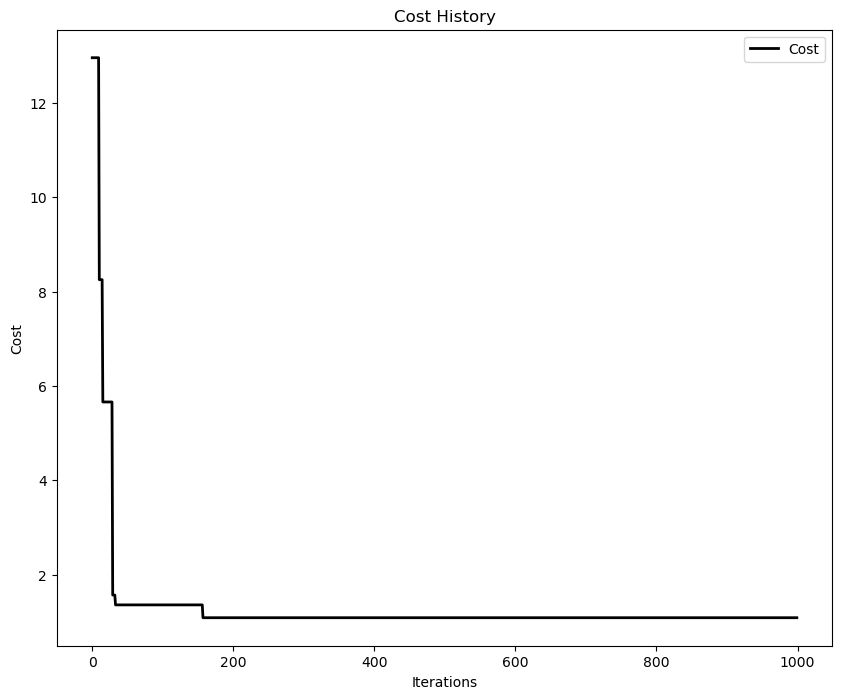

In [41]:
import matplotlib.pyplot as plt
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [43]:
from matplotlib import animation, rc
rc('animation', html='html5')